In [1]:
# Import required libraries
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnull, when, count, countDistinct
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.types import IntegerType, FloatType, DoubleType
import mlflow
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Configure SparkSession
spark = SparkSession.builder \
    .appName("Spark_MLlib_GBT_Label_Separation") \
    .master("local[*]") \
    .config("spark.driver.memory", "12g") \
    .config("spark.executor.memory", "6g") \
    .getOrCreate()

24/11/27 12:56:38 WARN Utils: Your hostname, Ghazis-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 166.87.130.137 instead (on interface en0)
24/11/27 12:56:38 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/27 12:56:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Configure MLflow for local tracking
mlflow.set_tracking_uri("file:./mlruns")  # Use local directory for tracking
experiment_name = "MLlib_GBTClassifier"

# Create the experiment if it doesn't exist
if not mlflow.get_experiment_by_name(experiment_name):
    mlflow.create_experiment(experiment_name)
mlflow.set_experiment(experiment_name)

# Configure paths for saving models and logs
MODEL_SAVE_DIR = "./models"
LOG_DIR = "./logs"

os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

In [4]:
# Load Reference Table
REFERENCE_TABLE_PATH = "../EDA/Results/reference_table_real.csv"
reference_table_missing_values_real = spark.read.csv(REFERENCE_TABLE_PATH, header=True)
# sort by 'Value Type' column
reference_table_missing_values_real = reference_table_missing_values_real.orderBy("Value Type")
reference_table_missing_values_real.show(truncate=False, n=99)

+-------------+------------------------------------------------------------+--------------------+-----------+--------------------+-------------------------+
|Tag          |Name                                                        |Unit                |Value Type |Unique Values (Real)|Missing Values (%) (Real)|
+-------------+------------------------------------------------------------+--------------------+-----------+--------------------+-------------------------+
|ESTADO-DHSV  |State of the DHSV (downhole safety valve)                   |[0, 0.5, 1]         |Categorical|2                   |57.8                     |
|ESTADO-M1    |State of the PMV (production master valve)                  |[0, 0.5, 1]         |Categorical|2                   |45.9                     |
|ESTADO-PXO   |State of the PXO (pig-crossover) valve                      |[0, 0.5, 1]         |Categorical|2                   |44.7                     |
|ESTADO-M2    |State of the AMV (annulus master valve)    

In [9]:
# Read datasets into PySpark DataFrames
data_dir = "../Cleaning & Preparation/Train Test (Scaled) Data"
train_data_spark = spark.read.parquet(os.path.join(data_dir, "scaled_train_data.parquet"))
test_data_spark = spark.read.parquet(os.path.join(data_dir, "scaled_test_data.parquet"))

# Define columns to exclude (non-feature columns)
exclude_columns = ['Instance', 'label', 'timestamp', 'class', 'target', 'state', 'well', 'id', 'DataType', '__index_level_0__']

# Extract all columns from the training data
all_columns = train_data_spark.columns

# Define feature names by excluding non-feature columns
feature_names = [col_name for col_name in all_columns if col_name not in exclude_columns]

target_name = "target"


In [10]:
# Print the feature names
print("Feature Names:")
for feature in feature_names:
    print(feature)

Feature Names:
ABER-CKGL_missing
ABER-CKP_missing
ESTADO-DHSV_missing
ESTADO-M1_missing
ESTADO-PXO_missing
ESTADO-M2_missing
ESTADO-SDV-GL_missing
ESTADO-SDV-P_missing
ESTADO-W1_missing
ESTADO-W2_missing
P-ANULAR_missing
ESTADO-XO_missing
P-JUS-CKGL_missing
P-MON-CKP_missing
P-JUS-CKP_missing
P-MON-CKGL_missing
P-PDG_missing
P-TPT_missing
QGL_missing
T-JUS-CKP_missing
T-MON-CKP_missing
T-PDG_missing
T-TPT_missing
ABER-CKGL
ABER-CKP
ESTADO-DHSV
ESTADO-M1
ESTADO-PXO
ESTADO-M2
ESTADO-SDV-GL
ESTADO-SDV-P
ESTADO-W1
ESTADO-W2
P-ANULAR
ESTADO-XO
P-JUS-CKGL
P-MON-CKP
P-JUS-CKP
P-MON-CKGL
P-PDG
P-TPT
QGL
T-JUS-CKP
T-MON-CKP
T-PDG
T-TPT


In [11]:
# Define the list of labels to process
labels_to_process = [1, 2, 3, 4, 5, 6, 7, 8, 9]

In [12]:
# Separate data by label into PySpark DataFrames
label_dataframes = {}
for label in labels_to_process:
    train_df_label = train_data_spark.filter(col("label") == label)
    test_df_label = test_data_spark.filter(col("label") == label)

    label_dataframes[label] = {
        "train": train_df_label,
        "test": test_df_label,
    }

In [8]:
# Function to verify data integrity
def verify_data(df, label):
    # Check for null values
    null_counts = df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).collect()[0].asDict()
    if any(null_counts.values()):
        print(f"Null values detected in label {label}: {null_counts}")
        raise ValueError(f"Null values detected in label {label}. Investigate the data.")

    # Verify column types
    for col_name in feature_names:
        col_type = [f.dataType for f in df.schema.fields if f.name == col_name][0]
        if not isinstance(col_type, (IntegerType, FloatType, DoubleType)):
            print(f"Column {col_name} in label {label} is of type {col_type}, expected numeric.")
            raise ValueError(f"Column {col_name} in label {label} is not numeric.")

    print(f"Label {label}: No nulls, all columns have valid types.")

# Separate the execution of the verification from the data separation
for label in labels_to_process:
    train_df_label = label_dataframes[label]['train']
    test_df_label = label_dataframes[label]['test']

    verify_data(train_df_label, f"{label}_train")
    verify_data(test_df_label, f"{label}_test")

24/11/27 09:44:59 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Label 1_train: No nulls, all columns have valid types.
Label 1_test: No nulls, all columns have valid types.


Label 2_train: No nulls, all columns have valid types.
Label 2_test: No nulls, all columns have valid types.


Label 3_train: No nulls, all columns have valid types.
Label 3_test: No nulls, all columns have valid types.


Label 4_train: No nulls, all columns have valid types.


Label 4_test: No nulls, all columns have valid types.


Label 5_train: No nulls, all columns have valid types.
Label 5_test: No nulls, all columns have valid types.
Label 6_train: No nulls, all columns have valid types.
Label 6_test: No nulls, all columns have valid types.


Label 7_train: No nulls, all columns have valid types.


Label 7_test: No nulls, all columns have valid types.


Label 8_train: No nulls, all columns have valid types.


Label 8_test: No nulls, all columns have valid types.


Label 9_train: No nulls, all columns have valid types.


Label 9_test: No nulls, all columns have valid types.


In [13]:
# Train a GBT model for each label
for label in labels_to_process:
    print(f"\nProcessing label: {label}")

    train_df = label_dataframes[label]["train"]
    test_df = label_dataframes[label]["test"]

    # Check if there's sufficient data
    if train_df.count() == 0 or test_df.count() == 0:
        print(f"Insufficient data for label {label}. Skipping this label.")
        continue

    # Assemble features into a feature vector
    assembler = VectorAssembler(inputCols=feature_names, outputCol="features")
    train_df = assembler.transform(train_df)
    test_df = assembler.transform(test_df)

    # Adjust model training section to include hyper-parameters with default values
    maxDepth = 5            # Maximum depth of the tree (default=5). Controls overfitting.
    maxBins = 32            # Maximum number of bins used for splitting features (default=32).
    maxIter = 20            # Number of iterations (trees) (default=20).
    stepSize = 0.1          # Learning rate (default=0.1). Controls the rate at which the model learns.
    subsamplingRate = 1.0   # Fraction of data to use for training each tree (default=1.0).
    lossType = "logistic"   # Loss function to minimize (default='logistic').
    minInstancesPerNode = 1 # Minimum instances per node (default=1).
    minInfoGain = 0.0       # Minimum information gain for a split (default=0.0).
    seed = 123              # Random seed for reproducibility (default=None).

    # Define the GBTClassifier with hyperparameters
    gbt = GBTClassifier(featuresCol="features", labelCol=target_name,
                        maxDepth=maxDepth,
                        maxBins=maxBins,
                        maxIter=maxIter,
                        stepSize=stepSize,
                        subsamplingRate=subsamplingRate,
                        lossType=lossType,
                        minInstancesPerNode=minInstancesPerNode,
                        minInfoGain=minInfoGain,
                        seed=seed)

    # Start an MLflow run
    with mlflow.start_run(run_name=f"GBT_Label_{label}"):
        # Train the model on the training set
        gbt_model = gbt.fit(train_df)

        # Predict on the test set
        test_predictions = gbt_model.transform(test_df)

        # Evaluate the model on the test set
        evaluator_roc = BinaryClassificationEvaluator(labelCol=target_name, metricName="areaUnderROC")
        auc_roc_test = evaluator_roc.evaluate(test_predictions)
        print(f"AUC-ROC on test set for label {label}: {auc_roc_test}")

        evaluator_pr = BinaryClassificationEvaluator(labelCol=target_name, metricName="areaUnderPR")
        auc_pr_test = evaluator_pr.evaluate(test_predictions)
        print(f"AUC-PR on test set for label {label}: {auc_pr_test}")

        # Include classification report and confusion matrix as evaluation results
        def compute_confusion_matrix(predictions, label_col, prediction_col):
            tp = predictions.filter((col(label_col) == 1) & (col(prediction_col) == 1)).count()
            tn = predictions.filter((col(label_col) == 0) & (col(prediction_col) == 0)).count()
            fp = predictions.filter((col(label_col) == 0) & (col(prediction_col) == 1)).count()
            fn = predictions.filter((col(label_col) == 1) & (col(prediction_col) == 0)).count()
            return {'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn}

        confusion_matrix_test = compute_confusion_matrix(test_predictions, target_name, 'prediction')

        # Compute key metrics for test set
        tp_test = confusion_matrix_test['tp']
        tn_test = confusion_matrix_test['tn']
        fp_test = confusion_matrix_test['fp']
        fn_test = confusion_matrix_test['fn']
        precision_test = tp_test / (tp_test + fp_test) if (tp_test + fp_test) > 0 else 0
        recall_test = tp_test / (tp_test + fn_test) if (tp_test + fn_test) > 0 else 0
        f1_score_test = 2 * precision_test * recall_test / (precision_test + recall_test) if (precision_test + recall_test) > 0 else 0

        print(f"Test Precision for label {label}: {precision_test}")
        print(f"Test Recall for label {label}: {recall_test}")
        print(f"Test F1 Score for label {label}: {f1_score_test}")
        print(f"Test Confusion Matrix: {confusion_matrix_test}")

        # Capture the feature importance for each model
        importances = gbt_model.featureImportances
        feature_importance_list = []
        for idx, imp in enumerate(importances):
            feature_importance_list.append((feature_names[idx], imp))

        # Convert to DataFrame
        feature_importance_df = pd.DataFrame(feature_importance_list, columns=["feature", "importance"])

        # Save feature importances to a file
        feature_importance_path = os.path.join(LOG_DIR, f"feature_importance_label_{label}.csv")
        feature_importance_df.to_csv(feature_importance_path, index=False)
        mlflow.log_artifact(feature_importance_path, artifact_path="feature_importance")

        # Save the model
        model_path = os.path.join(MODEL_SAVE_DIR, f"gbt_model_label_{label}")
        gbt_model.write().overwrite().save(model_path)
        mlflow.log_artifact(model_path, artifact_path="models")

        # Log parameters and metrics to MLflow
        mlflow.log_param("label", label)
        mlflow.log_param("maxDepth", maxDepth)
        mlflow.log_param("maxBins", maxBins)
        mlflow.log_param("maxIter", maxIter)
        mlflow.log_param("stepSize", stepSize)
        mlflow.log_param("subsamplingRate", subsamplingRate)
        mlflow.log_param("lossType", lossType)
        mlflow.log_param("minInstancesPerNode", minInstancesPerNode)
        mlflow.log_param("minInfoGain", minInfoGain)
        mlflow.log_param("seed", seed)

        # Log test metrics
        mlflow.log_metric("auc_roc_test", auc_roc_test)
        mlflow.log_metric("auc_pr_test", auc_pr_test)
        mlflow.log_metric("precision_test", precision_test)
        mlflow.log_metric("recall_test", recall_test)
        mlflow.log_metric("f1_score_test", f1_score_test)
        mlflow.log_metric("true_positives_test", tp_test)
        mlflow.log_metric("true_negatives_test", tn_test)
        mlflow.log_metric("false_positives_test", fp_test)
        mlflow.log_metric("false_negatives_test", fn_test)

        # End the MLflow run
        mlflow.end_run()

print("\nProcessing complete.")


Processing label: 1


24/11/27 13:01:34 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


AUC-ROC on test set for label 1: 0.5


24/11/27 13:01:36 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


AUC-PR on test set for label 1: 0.17106088046809698


Test Precision for label 1: 0
Test Recall for label 1: 0.0
Test F1 Score for label 1: 0
Test Confusion Matrix: {'tp': 0, 'tn': 47601, 'fp': 0, 'fn': 9823}

Processing label: 2
AUC-ROC on test set for label 2: 0.9747288562281575
AUC-PR on test set for label 2: 0.9529021037541734
Test Precision for label 2: 0.8849649234693877
Test Recall for label 2: 0.9523850377487989
Test F1 Score for label 2: 0.9174380165289256
Test Confusion Matrix: {'tp': 22202, 'tn': 54329, 'fp': 2886, 'fn': 1110}

Processing label: 3
AUC-ROC on test set for label 3: 0.42859075657552387
AUC-PR on test set for label 3: 0.8008437719712442
Test Precision for label 3: 0.8200074996875131
Test Recall for label 3: 0.7839848947171345
Test F1 Score for label 3: 0.8015916977566349
Test Confusion Matrix: {'tp': 98405, 'tn': 3600, 'fp': 21600, 'fn': 27114}

Processing label: 4


AUC-ROC on test set for label 4: 0.373401400650308


AUC-PR on test set for label 4: 0.5814253772251248


Test Precision for label 4: 0.6605895035983383
Test Recall for label 4: 0.9742251640060232
Test F1 Score for label 4: 0.7873221720316692
Test Confusion Matrix: {'tp': 480709, 'tn': 1412, 'fp': 246988, 'fn': 12718}

Processing label: 5


AUC-ROC on test set for label 5: 0.806431312061525
AUC-PR on test set for label 5: 0.8573871110930698
Test Precision for label 5: 0.9032047622930768
Test Recall for label 5: 0.5128965038203288
Test F1 Score for label 5: 0.6542619174198122
Test Confusion Matrix: {'tp': 22152, 'tn': 13183, 'fp': 2374, 'fn': 21038}

Processing label: 6
AUC-ROC on test set for label 6: 0.3375404226943844
AUC-PR on test set for label 6: 0.05199628955055645
Test Precision for label 6: 0.04787487249234954
Test Recall for label 6: 0.4785859959211421
Test F1 Score for label 6: 0.08704253214638973
Test Confusion Matrix: {'tp': 704, 'tn': 5624, 'fp': 14001, 'fn': 767}

Processing label: 7


24/11/27 13:05:29 WARN BlockManager: Asked to remove block rdd_3661_16, which does not exist
24/11/27 13:05:29 WARN BlockManager: Asked to remove block rdd_3661_11, which does not exist


AUC-ROC on test set for label 7: 0.6753187117751618


AUC-PR on test set for label 7: 0.9002684797374088


Test Precision for label 7: 0.8756374190827171
Test Recall for label 7: 0.9559781119829167
Test F1 Score for label 7: 0.9140457617645017
Test Confusion Matrix: {'tp': 1224846, 'tn': 26412, 'fp': 173959, 'fn': 56403}

Processing label: 8


AUC-ROC on test set for label 8: 0.9100174262969691


AUC-PR on test set for label 8: 0.9268066091163721


Test Precision for label 8: 0.9147258991008991
Test Recall for label 8: 0.9993898406574562
Test F1 Score for label 8: 0.9551854692580958
Test Confusion Matrix: {'tp': 527409, 'tn': 92506, 'fp': 49167, 'fn': 322}

Processing label: 9


AUC-ROC on test set for label 9: 0.9047983978042692


AUC-PR on test set for label 9: 0.5923720105831571


Test Precision for label 9: 0.4309350272133773
Test Recall for label 9: 0.34970811763410065
Test F1 Score for label 9: 0.3860956909288793
Test Confusion Matrix: {'tp': 31750, 'tn': 589990, 'fp': 41927, 'fn': 59040}

Processing complete.


In [15]:
# Show MLflow UI
import subprocess
subprocess.Popen("mlflow ui", shell=True)

<Popen: returncode: None args: 'mlflow ui'>

[2024-11-27 10:41:20 +0300] [85903] [INFO] Starting gunicorn 23.0.0
[2024-11-27 10:41:20 +0300] [85903] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2024-11-27 10:41:20 +0300] [85903] [ERROR] connection to ('127.0.0.1', 5000) failed: [Errno 48] Address already in use
[2024-11-27 10:41:21 +0300] [85903] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2024-11-27 10:41:21 +0300] [85903] [ERROR] connection to ('127.0.0.1', 5000) failed: [Errno 48] Address already in use
[2024-11-27 10:41:22 +0300] [85903] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2024-11-27 10:41:22 +0300] [85903] [ERROR] connection to ('127.0.0.1', 5000) failed: [Errno 48] Address already in use
[2024-11-27 10:41:23 +0300] [85903] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2024-11-27 10:41:23 +0300] [85903] [ERROR] connection to ('127.0.0.1', 5000) failed: [Errno 48] Address already in use
[2024-11-27 10:41:24 +0300] [85903] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2024-11-27 10:41:24 +0300] [85903] [

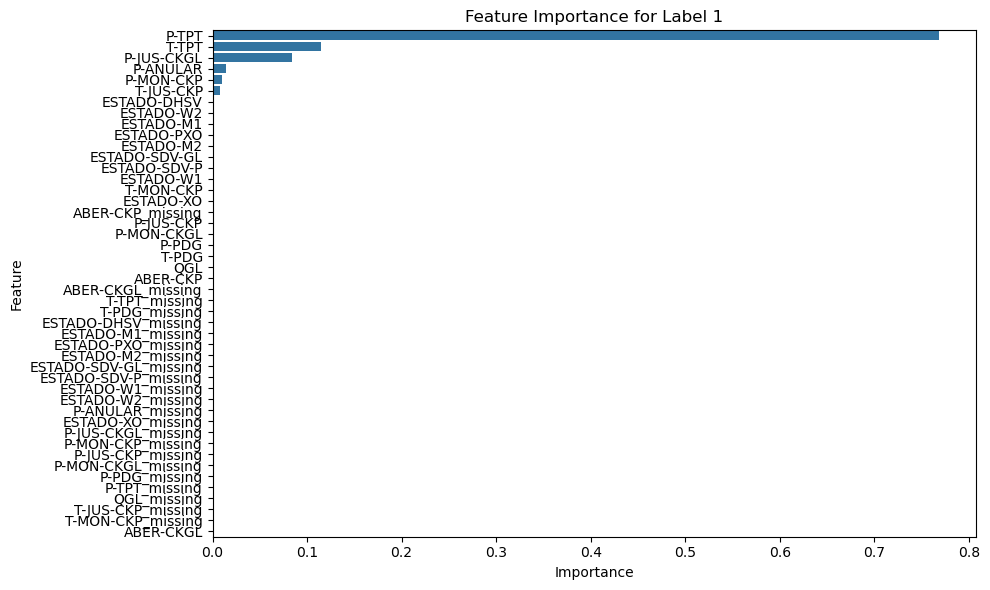

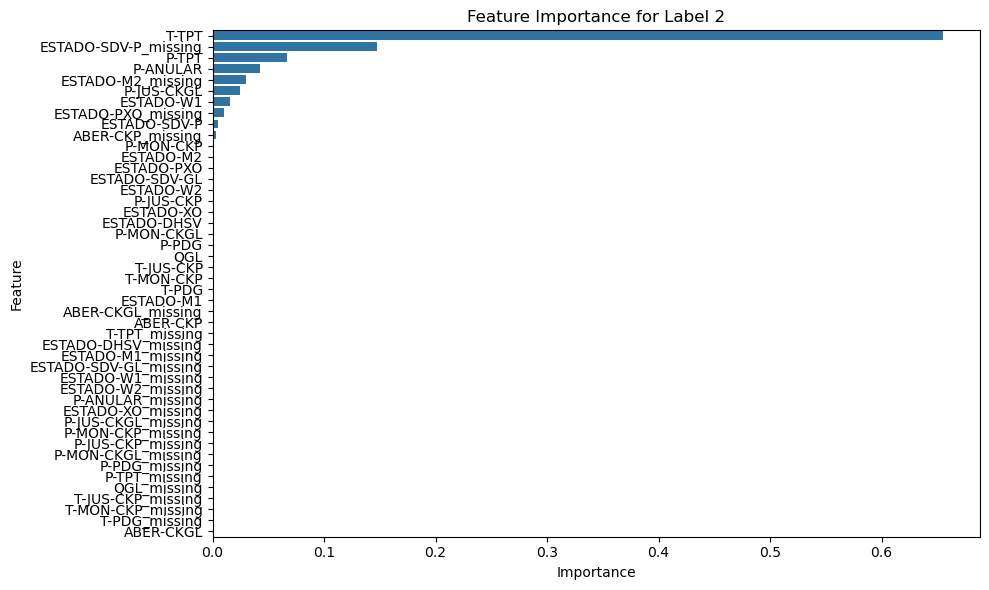

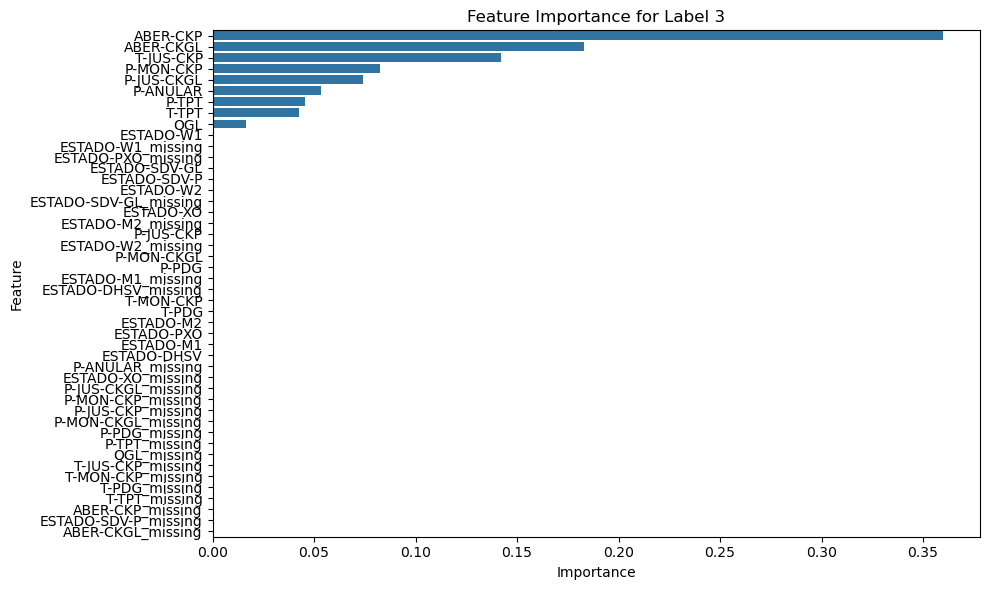

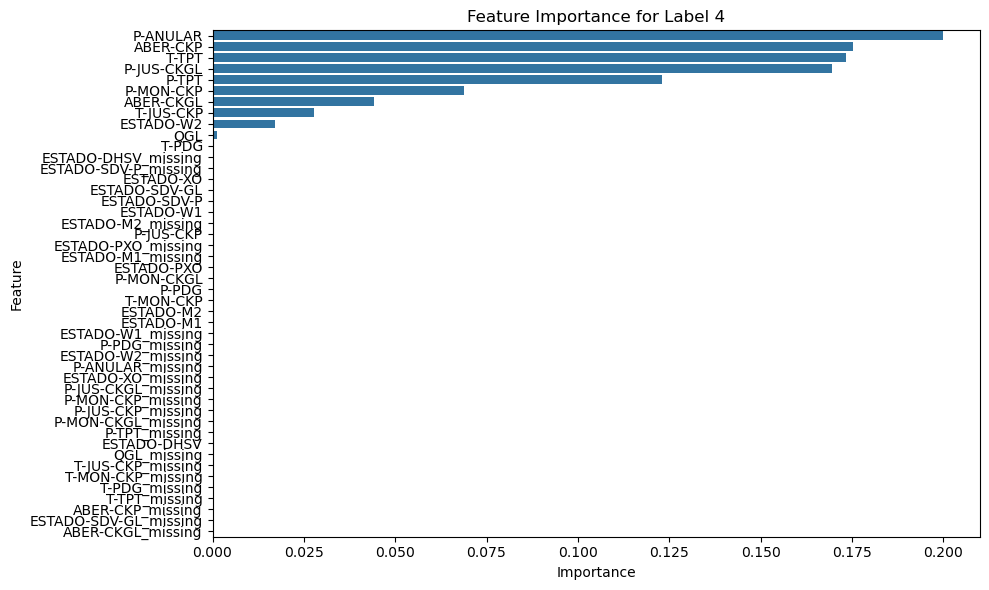

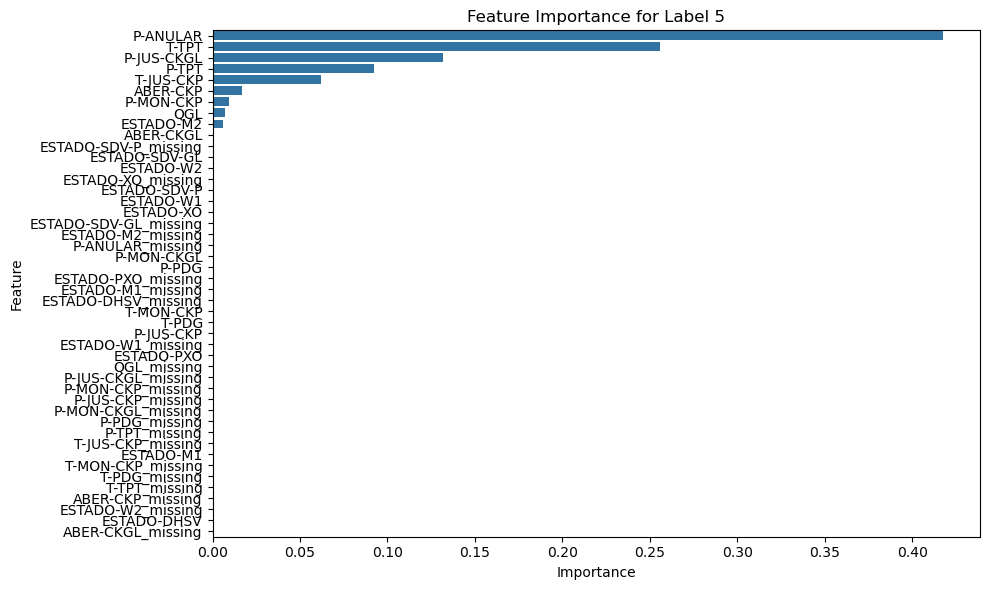

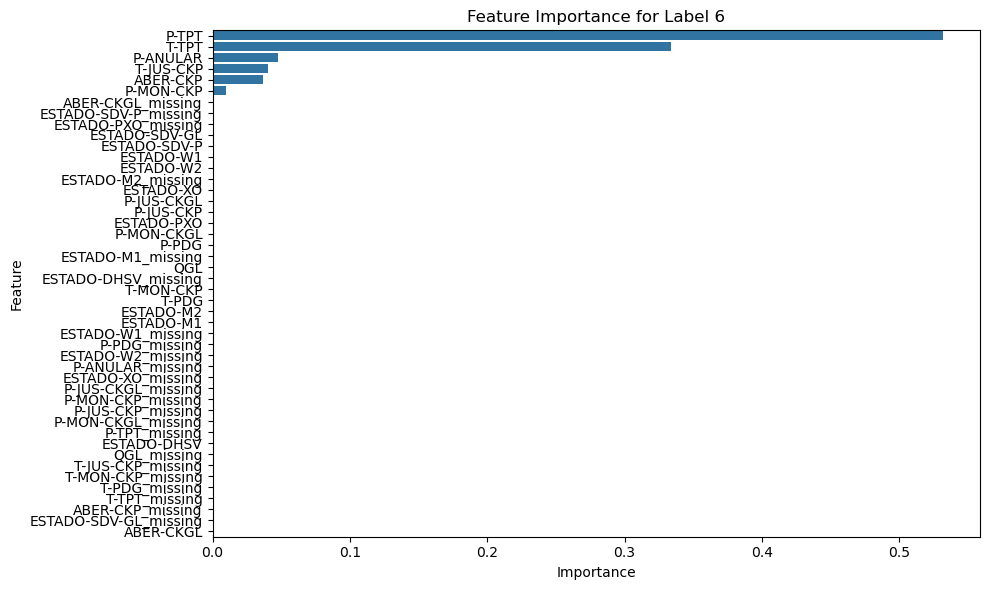

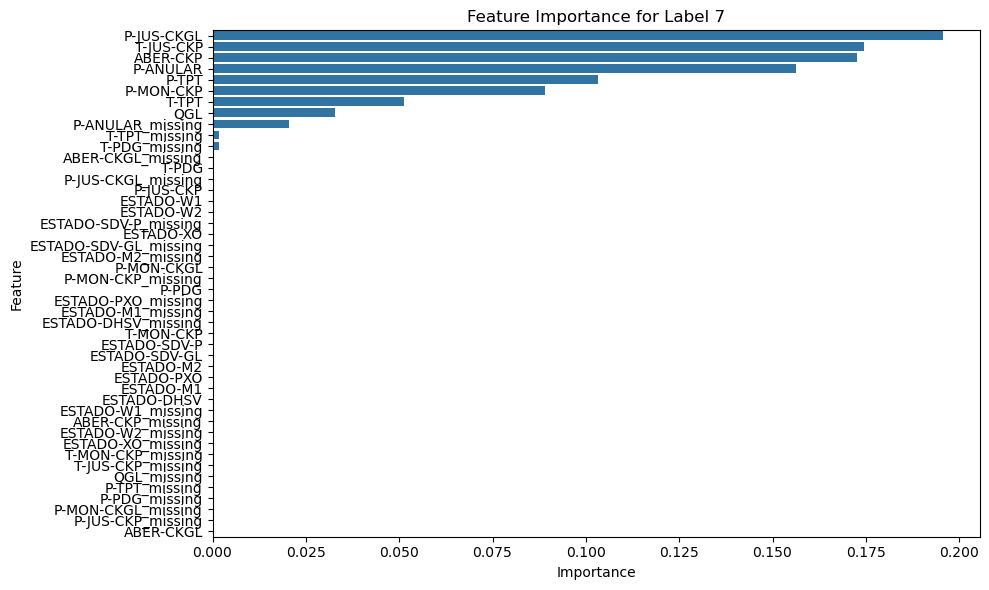

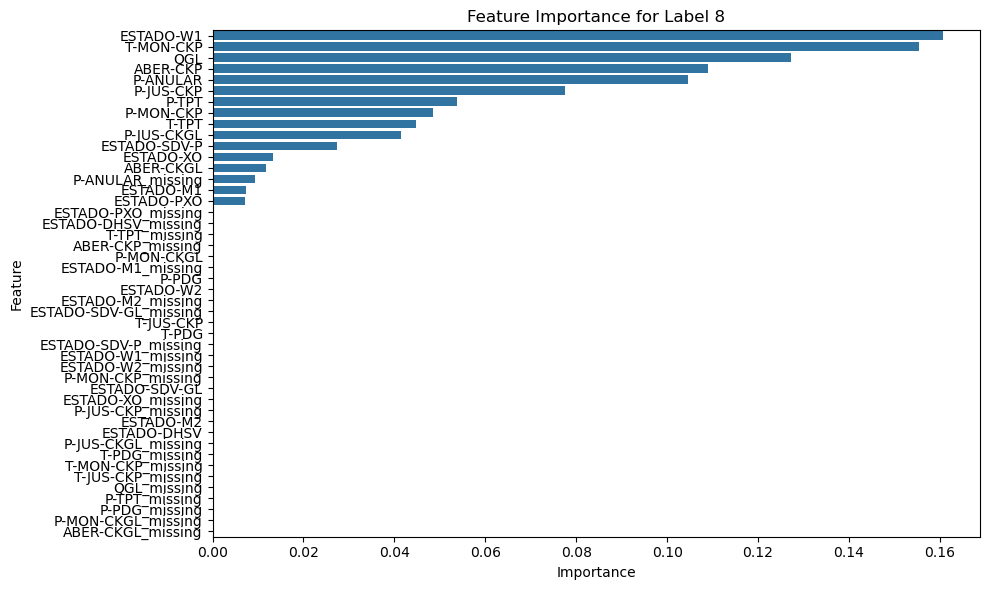

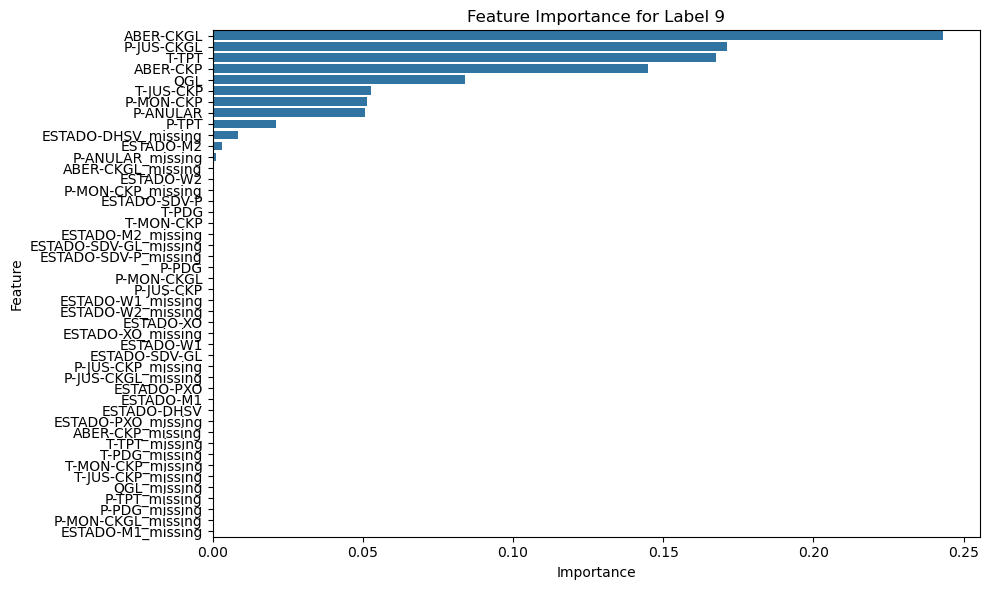

In [14]:
# read features importance from the saved csv files in the logs directory
# combine all the feature importance dataframes into one
feature_importance_dfs = []
for label in labels_to_process:
    feature_importance_path = os.path.join(LOG_DIR, f"feature_importance_label_{label}.csv")
    feature_importance_df = pd.read_csv(feature_importance_path)
    feature_importance_df["label"] = label
    feature_importance_dfs.append(feature_importance_df)

feature_importance_combined = pd.concat(feature_importance_dfs)

# plot subplot for each label
for label in labels_to_process:
    feature_importance_label = feature_importance_combined[feature_importance_combined["label"] == label]
    feature_importance_label = feature_importance_label.sort_values("importance", ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x="importance", y="feature", data=feature_importance_label)
    plt.title(f"Feature Importance for Label {label}")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()

    plt.savefig(os.path.join(LOG_DIR, f"feature_importance_label_{label}.png"))

In [ ]:
# Stop the SparkSession
spark.stop()